In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import cv2 as cv
import importlib

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

In [20]:
##Load scaler
scaler = pickle.load(open('models/scalers/dig4_256x256_unet_acc09886_scaler.pkl','rb'))
scaler_feat = pickle.load(open('models/scalers/dig4_256f_e5_cl2000_acc100_on_1000.pkl','rb')) 

In [3]:
###Loading models

###Prepare model

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights='./models/dig4_256x256_unet_acc09886')

    return model

model = unet()

In [258]:
###Model parameters
pic_h = 32
pic_w = 84
num_feat = 256
num_classes = 2000

###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        ###Num features is 'num_feat'
        ###Num classes is 'num_classes'
        
        #Input pixel numbers is pic_h*pic_w*1
        input_shape = (-1,pic_h,pic_w,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC*num_feat - feature vector
        #11: FC*num_classes - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init) #, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01)
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init) #, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01)
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(num_feat, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(num_classes)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([num_classes,num_feat], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,pic_h,pic_w,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        #tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        #tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        #tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        #tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, num_classes)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self, name, save_dir = "models"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_weights(os.path.join(save_dir, name))

    def load_model(self, name, load_dir = "models"):
        self.load_weights(os.path.join(load_dir, name))
        
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss

#Helpful function to control center loss during training    
def center_loss_progress(n_prog,n_iter, koeff, n_init = 0):
    return koeff*(n_prog+1)/(n_iter) if n_prog<n_iter else koeff   

model_feat = Model(0.005, dropout_rate = 0.15, variance_epsilon=1e-3)
model_feat_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()
model_feat.compile(opt, loss=model_feat_loss, metrics=["accuracy"])
model_feat.load_model("dig4_256f_e5_cl2000_acc100_on_1000") 

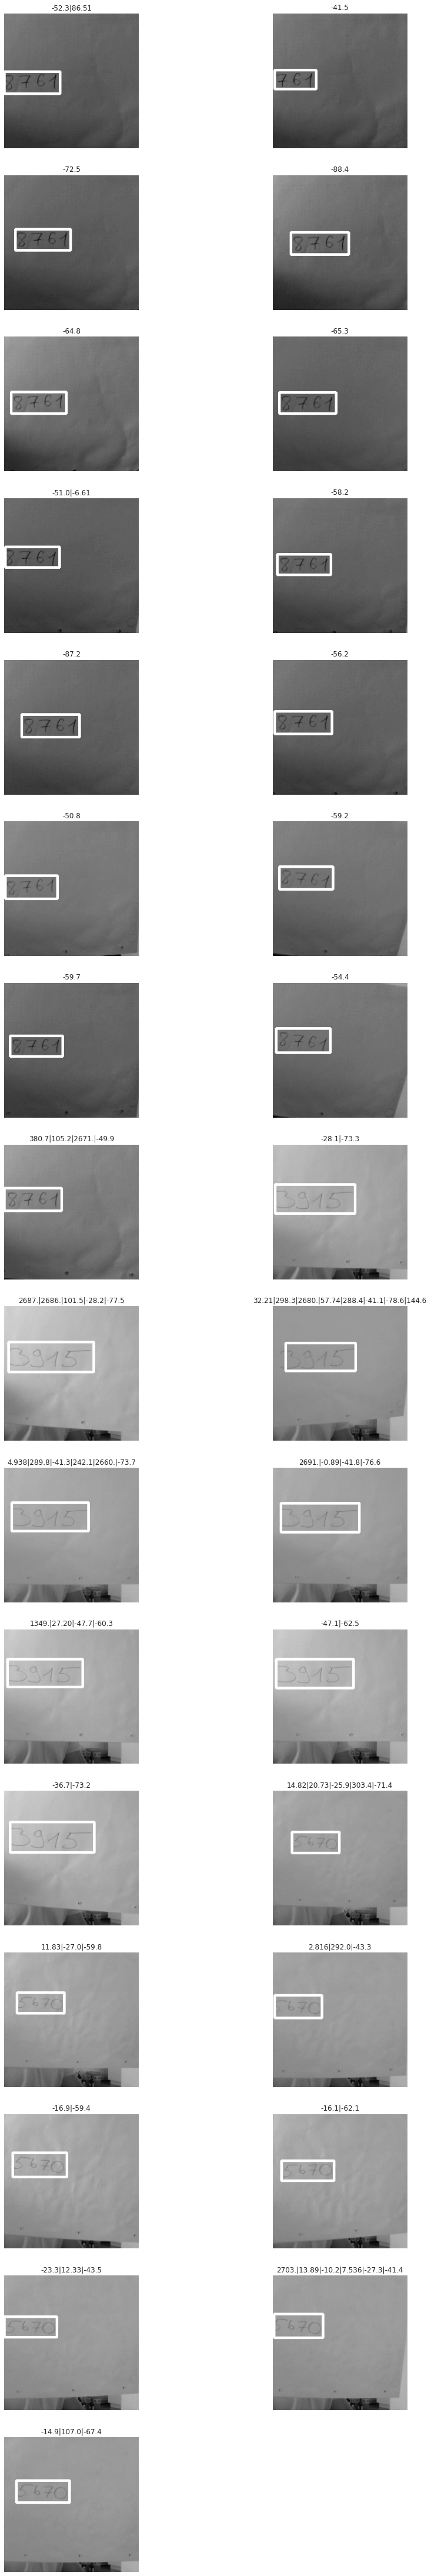

In [40]:
####Small test pipilene
importlib.reload(dgen)

###read images
test_images = dgen.Image_generator.load_from_folder("Data/4dig/test")
result_list = []
result_txt = []
cut_list = []

for img in test_images:
    ###read img
    #img_inp = cv.imread('Data/4dig/test/WIN_20200621_10_45_54_Pro.jpg', cv.IMREAD_UNCHANGED) 
    img_inp = img
    ###Cut image
    t,l,h,w = 0,img_inp.shape[1]-256,(img_inp.shape[0]-70),(img_inp.shape[0]-70)
    img_inp = img_inp[t:t+h,l:l+w]
    ###Convert to gray and resize
    img_gray = cv.cvtColor(img_inp, cv.COLOR_BGR2GRAY)
    img_gray = cv.resize(img_gray, (256,256), interpolation = cv.INTER_AREA) 
    ###Get inversion
    img_gray_inv = (255-img_gray)
    #Normalise image
    #mean, STD  = cv.meanStdDev(img_gray_inv)
    offset_pos = 3
    offset_neg = 3
    #img_gray = np.clip(img_gray_inv, mean - offset_neg*STD, mean + offset_pos*STD) 
    #print("Before normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    #img_gray_inv = cv.normalize(img_gray_inv, img_gray_inv, 0, 255, norm_type=cv.NORM_MINMAX)
    #print("After normalization Max:",img_gray_inv.max(),"Min:",img_gray_inv.min(), "Mean:",img_gray_inv.mean(), "Std:",img_gray_inv.std())
    ###Show prepared image
    ###dbug.Debug.show_image(img[:,:,[2,1,0]]) #for PIL format
    #dbug.Debug.show_image(img_gray_inv.reshape(pic_h,pic_w))
    ###rescale for NN
    img_gray_inv_scaled  = scaler.transform(img_gray_inv.reshape(-1,256*256))
    ###Make prediction
    predict = model(img_gray_inv_scaled.reshape(-1,256,256,1)).numpy()
    predict_tresh = cv.threshold(predict.reshape(256,256), 0.5, 1, cv.THRESH_BINARY)[1].astype('uint8')
    ###Find contours
    contours, hierarchy = cv.findContours(predict_tresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    result = predict.reshape(256,256)*255
    bb_list = [cv.boundingRect(contour) for contour in contours]
    if(bb_list):
        #bb = max(bb_list, key=lambda item: item[2])
        mp_find = []
        for bb in bb_list:
            cen_w = (bb[0]+bb[2]/2)
            cen_h = (bb[1]+bb[3]/2)
            mp_find.append((np.sqrt((128-cen_h)**2+(128-cen_w)**2) - 128)*1 + 1*(2688/(bb[2]*bb[3])))
        #result = cv.drawContours(result, contours[0], -1, 255, 3)
        bb = bb_list[np.argmin(mp_find)]
        cw = int((bb[0]+bb[2]/2))
        ch = int((bb[1]+bb[3]/2))
        half_size = int(np.max([bb[2],bb[3]])/2)
        pad_h = 2
        pad_w = 2
        boards = np.clip([ch-half_size-pad_h, cw-half_size-pad_w, ch+half_size+pad_h, cw+half_size+pad_w], 0, 255) 
        t,l,b,r = boards[0],boards[1],boards[2],boards[3]
        #print(t,l,b,r)
        cut_img = img_gray_inv[t:b,l:r]
        cut_resized = cv.resize(cut_img, (84,84), interpolation = cv.INTER_AREA)[26:26+32,:] 
        cut_list.append(cut_resized)
        result = cv.rectangle(img_gray, (bb[0], bb[1]), (bb[0]+bb[2], bb[1]+bb[3]), 255, 4)
        
    result_list.append(result)
    result_txt.append("|".join([str(i)[0:5] for i in mp_find]))

cut_list = np.array(cut_list)    
    
###Show result
dbug.Debug.show_images_list(result_list,result_txt, col_number = 2, height=5)

In [24]:
cut_list_rescaled = scaler_feat.transform(cut_list.reshape(cut_list.shape[0],-1)).astype('float32')

In [25]:
y_pred_logits, features_tf = model_feat(cut_list_rescaled)

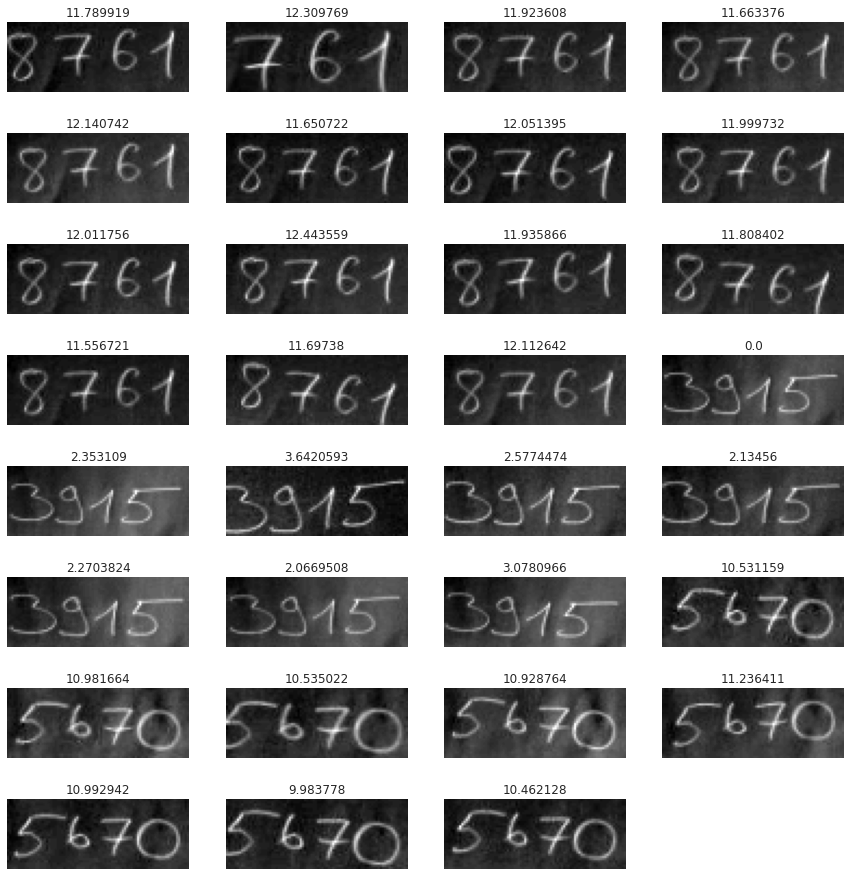

In [37]:
res_dist = []
for feat in features_tf:
    res_dist.append(np.linalg.norm(feat - features_tf[15]))
    
dbug.Debug.show_images_list(cut_list,res_dist, col_number = 4, height=2)

out shape (256, 256, 1)
out max 0.71087617  min 0.5  mean 0.5652402


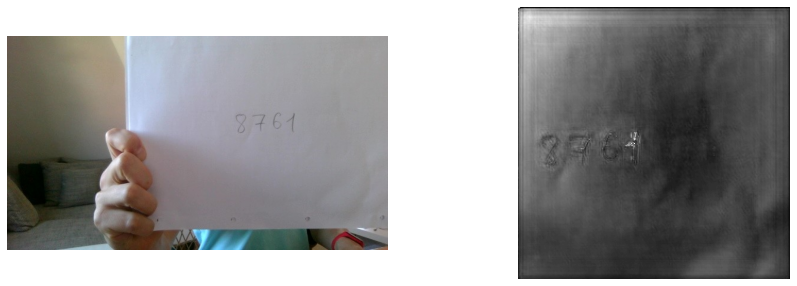

In [14]:
class Production(object):
    def __init__(self, pipeline):
        self.pipeline = pipeline
    
    def __call__(self, inp_data):
        return self.pipeline(inp_data)
    
    class Pipeline_base(object):
        def __init__(self, proc_layers):
            self.proc_layers = proc_layers
        
    class Pipeline_model_feat(Pipeline_base):
        def __init__(self, proc_layers):
            super().__init__(proc_layers)
        
        def __call__(self, inp_data):
            out_process_data = Production.Process_data(inp_data, info={})
            for proc_layer in self.proc_layers:
                out_process_data = proc_layer(out_process_data)
            return out_process_data
    
    class Layer(object):
        def __init__(self):
            self.proc_data = {}
    
    ###Process layer: Cut part of image
    class Layer_cut(Layer):
        def __init__(self, t,l,h,w):
            super().__init__()  
            self.t, self.l, self.h, self.w = t,l,h,w
            
        def __call__(self, process_data):
            inp_img = np.array(process_data.data)
            
            #Check inp shape (AxB) or (AxBxC)
            if((inp_img.ndim > 3) or (inp_img.ndim < 2)):
                raise ValueError("Wrong image dimension")
            
            #Check limits
            t = self.t if self.t<=inp_img.shape[0] else inp_img.shape[0]
            l = self.l if self.l<=inp_img.shape[1] else inp_img.shape[1]
            b = self.t+self.h if (self.t+self.h)<=inp_img.shape[0] else inp_img.shape[0]
            r = self.l+self.w if (self.l+self.w)<=inp_img.shape[1] else inp_img.shape[1]
            
            #Cut image
            out_img = inp_img[t:b,l:r,...]
            
            #Reshape (AxB)->(AxBx1)
            if (inp_img.ndim==2):
                out_img = out_img[...,None]
            
            #Add info
            process_data.info["channels"] = 1
            
            #Store data
            process_data.data = out_img
            
            return process_data
        
    ###Process layer: Convert to gray
    class Layer_to_gray(Layer):
        def __init__(self, rgb_weights = [0.2989, 0.5870, 0.1140], invert = False):
            super().__init__()  
            self.rgb_weights = rgb_weights
            self.invert = invert
            
        def __call__(self, process_data):
            process_data.data = (255-np.dot(process_data.data[...,:3], self.rgb_weights) if self.invert else np.dot(process_data.data[...,:3], self.rgb_weights))[...,None].astype(np.uint8)
            return process_data  

    ###Process layer: Convert gray to R or G or B
    class Layer_to_rgb(Layer):
        def __init__(self, mode = "r"):
            super().__init__()  
            self.mode = mode
            
        def __call__(self, process_data):
            out_shape = list(process_data.data.shape)
            out_shape[-1] = 2
            
            out = np.concatenate((process_data.data, np.zeros(out_shape,dtype=np.uint8)), axis=2)
            if self.mode == "b":
                process_data.data = out
            if self.mode == "g":
                process_data.data = out[...,[1,0,2]]
            if self.mode == "r":
                process_data.data = out[...,[1,2,0]]
            
            process_data.info["color"] = self.mode
            
            return process_data  

    ###Process layer: resize
    class Layer_resize(Layer):
        def __init__(self, w, h):
            super().__init__()  
            self.w, self.h = w, h
            
        def __call__(self, process_data):
            process_data.data = cv.resize(process_data.data, (self.w,self.h), interpolation = cv.INTER_AREA) 
            return process_data 
        
    ###Process layer: scaler
    class Layer_scaler(Layer):
        def __init__(self, file=""):
            super().__init__()  
            self.scaler = pickle.load(open(file,'rb'))
            
        def __call__(self, process_data):
            inp_shape = process_data.data.shape
            process_data.data = (self.scaler.transform(process_data.data.reshape(-1,np.prod(inp_shape)))).reshape(inp_shape)
            return process_data 
        
    ###Process layer: model
    class Layer_model(Layer):
        def __init__(self, model, input_shape, output_shape=None):
            super().__init__()  
            self.model = model
            self.input_shape = input_shape
            self.output_shape = output_shape
            
        def __call__(self, process_data):
            
            result = self.model(process_data.data.reshape(self.input_shape)).numpy()
            
            if self.output_shape is not None:
                result = result.reshape(self.output_shape)
            else:
                result = result.reshape(self.input_shape[1:])
                
            process_data.data = result
            return process_data 
        
    ###Process layer: normalize (-STD*k|<--mean(+/-)-->|STD*k)->Normalize
    class Layer_normalize(Layer):
        def __init__(self, mean_shift=0, std_offset_pos=1, std_offset_neg=1):
            super().__init__()  
            
            self.mean_shift, self.std_offset_pos, self.std_offset_neg = mean_shift, std_offset_pos, std_offset_neg
            
        def __call__(self, process_data):
            mean, STD  = cv.meanStdDev(process_data.data)
            process_data.data = np.clip(process_data.data + (mean*self.mean_shift), mean*(1+self.mean_shift) - self.std_offset_neg*STD, mean*(1+self.mean_shift) + self.std_offset_pos*STD )# 
            process_data.data = np.clip(process_data.data, 0, 255)
            process_data.data = cv.normalize(process_data.data, None, 0, 255, norm_type=cv.NORM_MINMAX)
            return process_data
        
    class Process_data(object):
        def __init__(self, data, info={}):
            self.data = data
            self.info = info

###Create process class implementation      
class Production_unit(Production):
    def __init__(self):
        
        ###Initialize process layers
        self.layer_1_cut = Production.Layer_cut(t=0,l=360,h=280,w=280)
        self.layer_2_gray = Production.Layer_to_gray(invert=True)
        #self.layer_3_rgb = Production.Layer_to_rgb(mode="b")
        self.layer_3_resize = Production.Layer_resize(w=256,h=256)
        #self.layer_4_normalize = Production.Layer_normalize(mean_shift=0, std_offset_pos=3, std_offset_neg=3)
        self.layer_5_scaler = Production.Layer_scaler(file="models/scalers/dig4_256x256_unet_acc09886_scaler.pkl")
        self.layer_6_model = Production.Layer_model(model=model, input_shape = (-1,256,256,1), output_shape = (256,256,1))
         
        
        ###Initialise pipeline
        self.pipeline = Production.Pipeline_model_feat(
            proc_layers = [
                self.layer_1_cut,
                self.layer_2_gray,
                self.layer_3_resize,
                #self.layer_4_normalize,
                self.layer_5_scaler,
                self.layer_6_model
            ]
        )
        
        super().__init__(self.pipeline)      

production = Production_unit()

out = production(test_image)

print("out shape",out.data.shape)
print("out max",out.data.max(), " min",out.data.min(), " mean",out.data.mean())
dbug.Debug.show_images_list([test_image[:,:,[2,1,0]],out.data.reshape(out.data.shape[0],out.data.shape[1])], col_number = 2, height=5)


In [ ]:
ar = np.array([
    [1,2,3]
])

In [238]:
scaler = pickle.load(open('models/scalers/dig4_256x256_unet_acc09886_scaler.pkl','rb'))
scaler_feat = pickle.load(open('models/scalers/dig4_256f_e5_cl2000_acc100_on_1000.pkl','rb')) 

120

In [5]:
test_images = dgen.Image_generator.load_from_folder("Data/4dig/test")
test_image = test_images[0]
test_image.shape

(360, 640, 3)